In [ ]:
!unzip "/content/drive/MyDrive/final_dataset.zip"

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import backend as K
from keras.utils.np_utils import to_categorical 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import models
import itertools
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

**Dataset Preprocessing**

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True,vertical_flip=True,height_shift_range=0.1,width_shift_range=0.1)

Validation_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(r'/content/content/Dataset/train',target_size = (224, 224),batch_size = 150,class_mode = 'categorical')

validation_set = Validation_datagen.flow_from_directory(r'/content/content/Dataset/valid',target_size = (224, 224),batch_size = 150,class_mode = 'categorical')

test_set = Validation_datagen.flow_from_directory(r'/content/content/Dataset/test',target_size=(224, 224),batch_size=150,class_mode='categorical',shuffle=False)


Found 34146 images belonging to 13 classes.
Found 9751 images belonging to 13 classes.
Found 4898 images belonging to 13 classes.


**CNN Model**

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (3, 3), activation='relu',input_shape = (28,28,3)))
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(13, activation='softmax'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 26, 26, 8)         224       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_24 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 12, 12, 16)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 10, 10, 32)        4640      
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 8, 8, 32)        

In [ ]:
from tensorflow.keras.applications import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input

model = Sequential()
model.add(VGG19(weights ='imagenet', pooling = 'avg', include_top=False,input_tensor=(Input(shape=(224,224,3)))))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(13,activation = 'softmax'))
model.layers[0].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
import tensorflow as tf

from keras.callbacks import ModelCheckpoint
filepath="/content/drive/MyDrive/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
 
history=model.fit_generator(
    training_set,
    steps_per_epoch=int(34146/150),
    epochs=50,
    validation_data=validation_set,
    validation_steps=int(9751/150),
    callbacks=callbacks_list)
 
model.save_weights('/content/drive/MyDrive/final_weights.h5')
model.save('/content/drive/MyDrive/final_model_weight.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Unrecognized location 'upper_left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


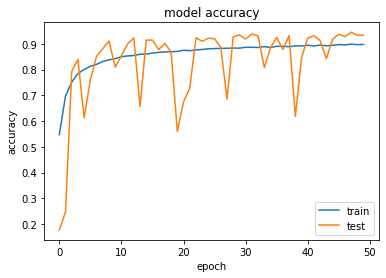

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Unrecognized location 'upper_left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  app.launch_new_instance()


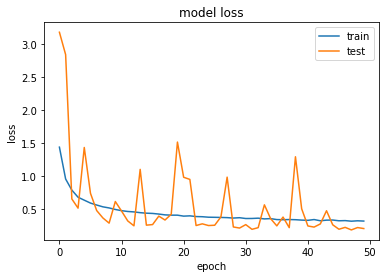

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper_left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper_left')
plt.show()

In [ ]:
target_names = []

for key in test_set.class_indices:
    target_names.append(key)
print(len(target_names))

13


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from keras.models import load_model

# load model
model = load_model('/content/drive/MyDrive/weights.best.hdf5')

score = model.evaluate(test_set, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 94.63%


In [ ]:
Y_pred = model.predict_generator(test_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_set.classes, y_pred)
print(confusion_matrix(test_set.classes, y_pred))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[744   0  22   0   0   0   1   0   2   0   0   0   0]
 [  0 337   0   0   0   0   0   0   0   0   0   0   0]
 [  1   2 917   3   0   1   0   0   5   0   0   0   0]
 [  3   3  11 914   9   0   4   1   5   0   2   1   1]
 [  0   1   1   3 425   3   4   0   0   0   0   0   0]
 [  8   0   5   2   7 292   1   3   2   0   4   0   0]
 [  0   1   1  23   0   0 181   0   0   1   0   0   0]
 [  0   2   0   8   1   0   3 172   0   0   9   0   1]
 [  5   0   6   6   0   1   0   0 172   0   0   0   1]
 [  1   0   0   4   2   0   0   0   0 184   1   0   0]
 [  0   1   0   2   0   1   0  27   2   1 164   0   0]
 [  0   2   1   1   0   6   2   0   0   2   1  75   0]
 [  0   5   5   3   0   0   0   1   2   0   0   0  58]]


In [ ]:
print(classification_report(test_set.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           +       0.98      0.97      0.97       769
           0       0.95      1.00      0.98       337
           1       0.95      0.99      0.97       929
           2       0.94      0.96      0.95       954
           3       0.96      0.97      0.96       437
           4       0.96      0.90      0.93       324
           5       0.92      0.87      0.90       207
           6       0.84      0.88      0.86       196
           7       0.91      0.90      0.90       191
           8       0.98      0.96      0.97       192
           9       0.91      0.83      0.87       198
           r       0.99      0.83      0.90        90
           s       0.95      0.78      0.86        74

    accuracy                           0.95      4898
   macro avg       0.94      0.91      0.92      4898
weighted avg       0.95      0.95      0.95      4898



Normalized confusion matrix


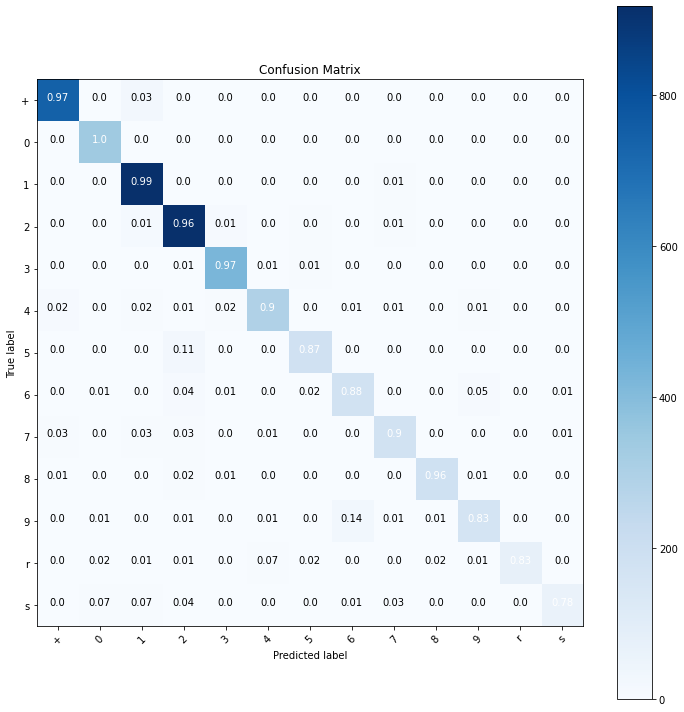

In [ ]:
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')